## ETAP 2: Analiza wzorców i ryzyka halucynacji

Porównanie 12 strategii promptu: wpływ na accuracy, zmienność odpowiedzi, detekcja ryzyka.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, HTML
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

### 1. Przygotowanie danych i metryki

In [9]:
from glob import glob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

saved_files = glob('saved_responses/parsed_responses_*.csv')
if not saved_files:
    raise FileNotFoundError("Brak plików wyników. Uruchom najpierw test.ipynb.")

latest_file = max(saved_files, key=Path)
parsed_df = pd.read_csv(latest_file, index_col=0)
print(f"[Wczytano] {Path(latest_file).name} - {parsed_df.shape}")

df = pd.read_csv('prompts2.csv', sep=';')
y_true = df['Flag'].values
print(f"[Dataset] {len(y_true)} promptów ({(y_true==1).sum()} prawda, {(y_true==0).sum()} fałsz)")

metrics_list = []
for col in parsed_df.columns:
    y_pred = parsed_df[col].values
    valid_mask = ~np.isnan(y_pred)
    
    if valid_mask.sum() > 0:
        y_true_v = y_true[valid_mask]
        y_pred_v = y_pred[valid_mask]
        
        metrics_list.append({
            'Strategy': col,
            'Accuracy': accuracy_score(y_true_v, y_pred_v),
            'Precision': precision_score(y_true_v, y_pred_v, zero_division=0),
            'Recall': recall_score(y_true_v, y_pred_v, zero_division=0),
            'F1': f1_score(y_true_v, y_pred_v, zero_division=0),
            'Valid': valid_mask.sum(),
            'NaN': (~valid_mask).sum()
        })

metrics_df = pd.DataFrame(metrics_list).sort_values('Accuracy', ascending=False)
print(f"\n[Metryki] {len(metrics_df)} strategii")
print(metrics_df.to_string(index=False))

[Wczytano] parsed_responses_FIXED_2025-12-30_21-36-24.csv - (60, 12)
[Dataset] 60 promptów (28 prawda, 32 fałsz)

[Metryki] 12 strategii
           Strategy  Accuracy  Precision   Recall       F1  Valid  NaN
             Prompt  0.600000   0.566667 0.607143 0.586207     60    0
    Negative_prompt  0.600000   0.562500 0.642857 0.600000     60    0
  Chain_of_thoughts  0.600000   0.552632 0.750000 0.636364     60    0
 Uncertainty_prompt  0.600000   0.555556 0.714286 0.625000     60    0
            Tipping  0.583333   0.534884 0.821429 0.647887     60    0
     Sceptical_role  0.583333   0.636364 0.250000 0.358974     60    0
    Positive_prompt  0.566667   0.525000 0.750000 0.617647     60    0
Negative_Extra_role  0.550000   0.521739 0.428571 0.470588     60    0
Positive_Extra_role  0.533333   0.500000 0.500000 0.500000     60    0
   Scrambled_prompt  0.533333   0.000000 0.000000 0.000000     60    0
        High_stakes  0.516667   0.461538 0.214286 0.292683     60    0
     Random

In [10]:
print("\n[Zmienność inter-strategiowa]")

variability_data = []
for idx in range(len(parsed_df)):
    row = parsed_df.iloc[idx].dropna()
    
    if len(row) > 0:
        unique_preds = row.unique()
        has_conflict = len(unique_preds) > 1
        agreements_with_true = (row == y_true[idx]).sum()
        disagreements_with_true = (row != y_true[idx]).sum()
        
        variability_data.append({
            'Idx': idx,
            'Prompt': df.iloc[idx]['Prompt'][:60] + '...',
            'True': int(y_true[idx]),
            'N_Strategies': len(row),
            'Unique_Preds': len(unique_preds),
            'Has_Conflict': has_conflict,
            'Std': row.std(),
            'Consensus': 'STRONG' if disagreements_with_true == 0 or agreements_with_true == 0 else 'WEAK'
        })

var_df = pd.DataFrame(variability_data).sort_values('Std', ascending=False)

print(f"Top 10 konfliktów:")
print(var_df[var_df['Has_Conflict']].head(10).to_string(index=False))

print(f"\nStatystyka: {var_df['Has_Conflict'].sum()}/{len(var_df)} konfliktów ({var_df['Has_Conflict'].sum()/len(var_df)*100:.1f}%), std={var_df['Std'].mean():.3f}")


[Zmienność inter-strategiowa]
Top 10 konfliktów:
 Idx                                                          Prompt  True  N_Strategies  Unique_Preds  Has_Conflict      Std Consensus
   1 Skończona addytywność prawdopodobieństwa jest warunkiem siln...     0            12             2          True 0.522233      WEAK
  24 Rozkład LU polega na przedstawieniu macierzy w postaci ilocz...     1            12             2          True 0.522233      WEAK
  25 Błąd obcięcia jest tożsamy z błędem zaokrąglenia i wynika wy...     0            12             2          True 0.522233      WEAK
  59 Funkcje sklejane trzeciego stopnia (splajny) są funkcjami ci...     0            12             2          True 0.522233      WEAK
  49 Sigma-ciało generowane przez rodzinę zbiorów to największe s...     0            12             2          True 0.522233      WEAK
  12 Zbieżność z prawdopodobieństwem 1 implikuje zbieżność według...     1            12             2          True 0.514929      WEA


[Macierz przejść między strategiami]


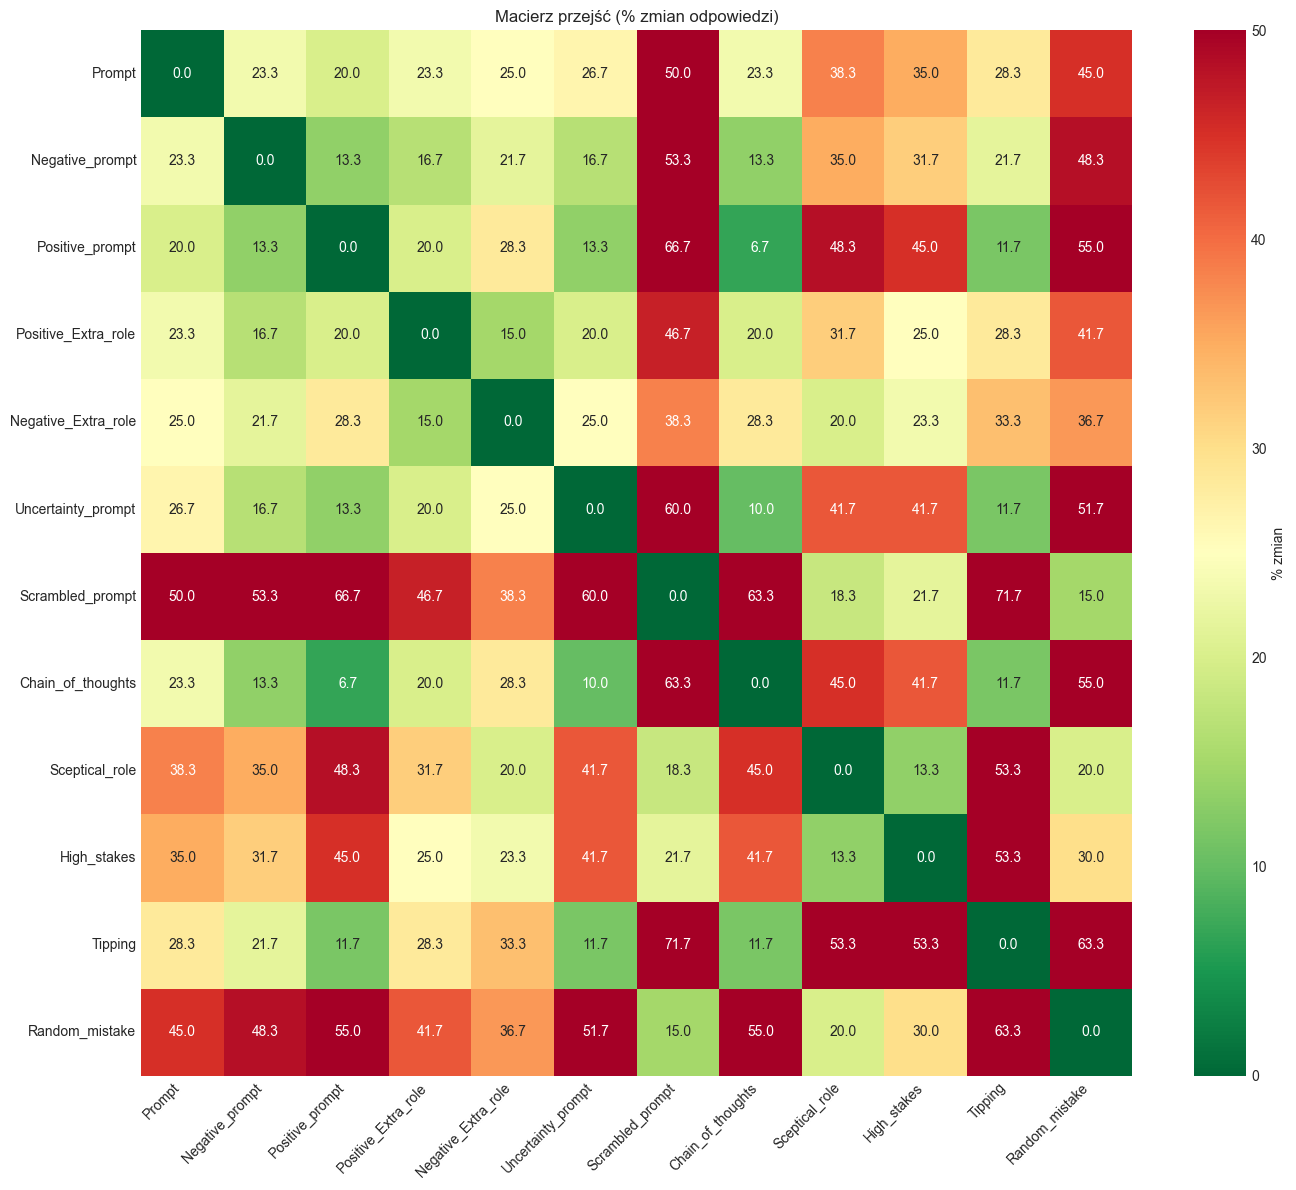


Top 10 par:
         Strategy1         Strategy2   Change%
  Scrambled_prompt           Tipping 71.666667
   Positive_prompt  Scrambled_prompt 66.666667
  Scrambled_prompt Chain_of_thoughts 63.333333
           Tipping    Random_mistake 63.333333
Uncertainty_prompt  Scrambled_prompt 60.000000
   Positive_prompt    Random_mistake 55.000000
 Chain_of_thoughts    Random_mistake 55.000000
       High_stakes           Tipping 53.333333
    Sceptical_role           Tipping 53.333333
   Negative_prompt  Scrambled_prompt 53.333333


In [11]:
print("\n[Macierz przejść między strategiami]")

transition_matrix = np.zeros((len(parsed_df.columns), len(parsed_df.columns)))

for i, col1 in enumerate(parsed_df.columns):
    for j, col2 in enumerate(parsed_df.columns):
        mask = (~np.isnan(parsed_df[col1])) & (~np.isnan(parsed_df[col2]))
        if mask.sum() > 0:
            changes = (parsed_df[col1][mask] != parsed_df[col2][mask]).sum()
            pct = changes / mask.sum() * 100
            transition_matrix[i][j] = pct

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(transition_matrix, 
            xticklabels=parsed_df.columns, 
            yticklabels=parsed_df.columns,
            annot=True, 
            fmt='.1f', 
            cmap='RdYlGn_r',
            cbar_kws={'label': '% zmian'},
            ax=ax,
            vmin=0, vmax=50)
ax.set_title('Macierz przejść (% zmian odpowiedzi)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

transitions_list = []
for i, col1 in enumerate(parsed_df.columns):
    for j, col2 in enumerate(parsed_df.columns):
        if i < j:
            transitions_list.append({
                'Strategy1': col1,
                'Strategy2': col2,
                'Change%': transition_matrix[i][j]
            })

transitions_df = pd.DataFrame(transitions_list).sort_values('Change%', ascending=False)
print("\nTop 10 par:")
print(transitions_df.head(10).to_string(index=False))

### 2. Interfejs interaktywny - eksploracja przypadków

In [12]:
def create_interactive_explorer():
    output_area = widgets.Output()
    
    idx_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(parsed_df)-1,
        description='Prompt ID:',
        continuous_update=False
    )
    
    def update_display(idx):
        with output_area:
            output_area.clear_output()
            
            original_prompt = df.iloc[idx]['Prompt']
            ground_truth = int(y_true[idx])
            
            print(f"[Prompt #{idx}] {original_prompt[:120]}...")
            print(f"Ground Truth: {ground_truth}\n")
            
            results = []
            for strategy in parsed_df.columns:
                pred = parsed_df[strategy].iloc[idx]
                if not np.isnan(pred):
                    pred = int(pred)
                    is_correct = (pred == ground_truth)
                    status = 'OK' if is_correct else 'FAIL'
                    results.append(f"  {strategy:25s} -> {pred} [{status}]")
                else:
                    results.append(f"  {strategy:25s} -> NaN [ERROR]")
            
            print("\n".join(results))
            
            row_var = var_df[var_df['Idx'] == idx]
            if len(row_var) > 0:
                print(f"\nZmienność: std={row_var['Std'].values[0]:.3f}, unikalne={int(row_var['Unique_Preds'].values[0])}")
    
    idx_slider.observe(lambda change: update_display(change['new']), names='value')
    update_display(0)
    
    display(idx_slider, output_area)

create_interactive_explorer()

IntSlider(value=0, continuous_update=False, description='Prompt ID:', max=59)

Output()

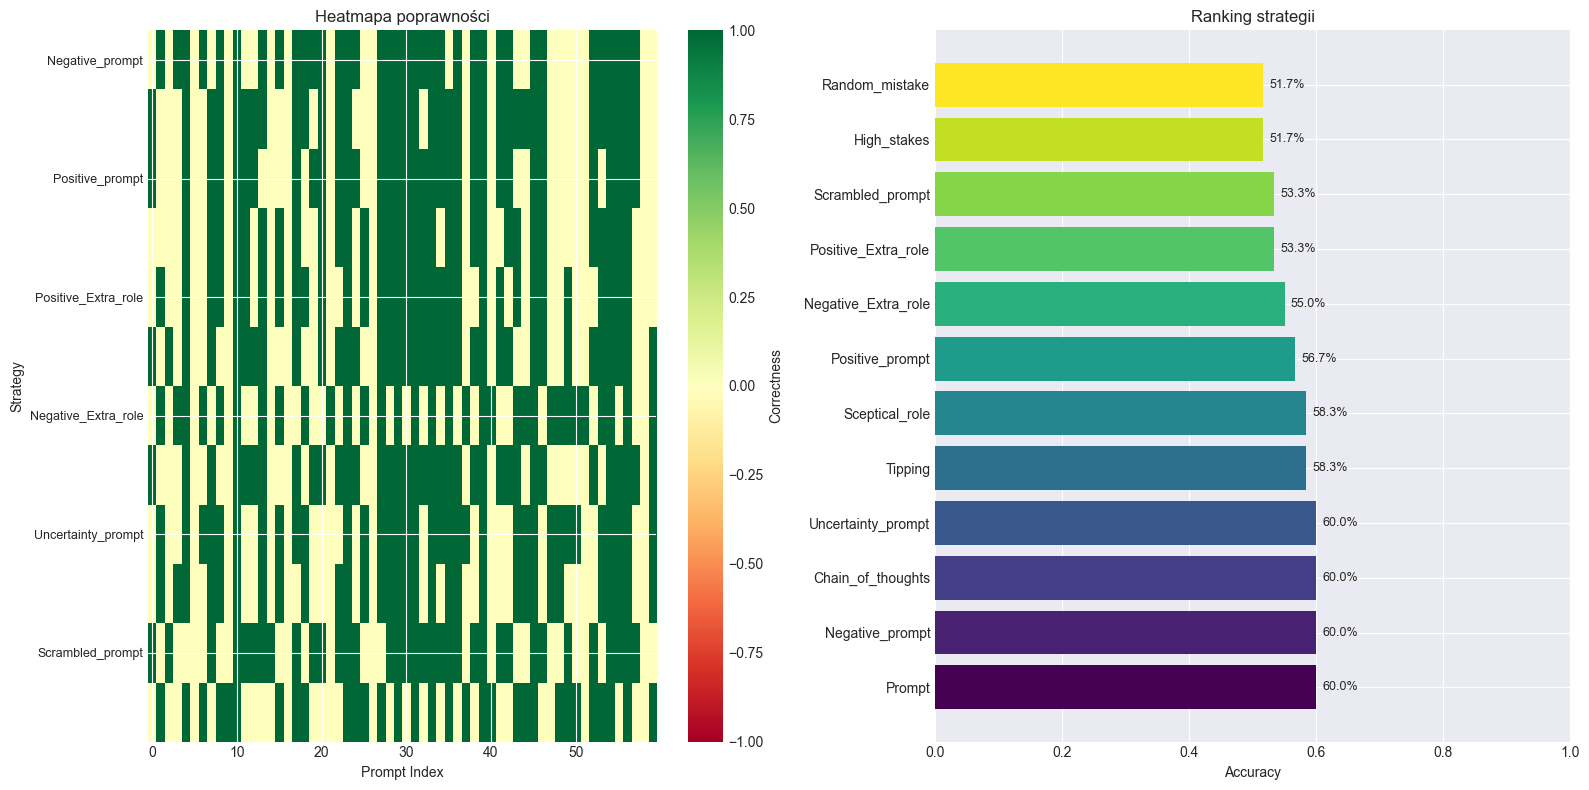

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

correctness_matrix = np.zeros((len(parsed_df.columns), len(parsed_df)))
for i, strategy in enumerate(parsed_df.columns):
    for j in range(len(parsed_df)):
        pred = parsed_df[strategy].iloc[j]
        if np.isnan(pred):
            correctness_matrix[i][j] = -1
        else:
            correctness_matrix[i][j] = 1 if pred == y_true[j] else 0

im1 = ax1.imshow(correctness_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
ax1.set_xlabel('Prompt Index')
ax1.set_ylabel('Strategy')
ax1.set_yticklabels(parsed_df.columns, fontsize=9)
ax1.set_title('Heatmapa poprawności')
plt.colorbar(im1, ax=ax1, label='Correctness')

strategies = metrics_df['Strategy'].values
accuracies = metrics_df['Accuracy'].values
colors = plt.cm.viridis(np.linspace(0, 1, len(strategies)))

ax2.barh(strategies, accuracies, color=colors)
ax2.set_xlabel('Accuracy')
ax2.set_title('Ranking strategii')
ax2.set_xlim(0, 1)
for i, (s, acc) in enumerate(zip(strategies, accuracies)):
    ax2.text(acc + 0.01, i, f'{acc:.1%}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

### 3. Analiza wzorców: wpływ zmian promptu

In [14]:
print("\n[Analiza kategorii strategii]")

categories = {
    'Positive Framing': ['Positive_prompt'],
    'Negative Framing': ['Negative_prompt'],
    'Role-Playing (Expert)': ['Positive_Extra_role'],
    'Role-Playing (Dummy)': ['Negative_Extra_role'],
    'Chain-of-Thought': ['Chain_of_thoughts'],
    'Uncertainty': ['Uncertainty_prompt'],
    'Scepticism': ['Sceptical_role'],
    'Incentive': ['Tipping', 'High_stakes'],
    'Scramble/Noise': ['Scrambled_prompt', 'Random_mistake']
}

category_performance = []
for cat_name, cat_strategies in categories.items():
    cat_metrics = metrics_df[metrics_df['Strategy'].isin(cat_strategies)]
    if len(cat_metrics) > 0:
        avg_acc = cat_metrics['Accuracy'].mean()
        baseline_acc = metrics_df[metrics_df['Strategy'] == 'Prompt']['Accuracy'].values[0]
        impact = avg_acc - baseline_acc
        
        category_performance.append({
            'Category': cat_name,
            'Avg_Accuracy': avg_acc,
            'Baseline': baseline_acc,
            'Impact': impact,
            'N_Strategies': len(cat_strategies)
        })
        
        impact_text = "pomaga" if impact > 0.02 else "szkodzi" if impact < -0.02 else "neutralne"
        print(f"{cat_name:25s} | {avg_acc:.1%} | {impact:+.1%} [{impact_text}]")

cat_perf_df = pd.DataFrame(category_performance).sort_values('Impact', ascending=False)


[Analiza kategorii strategii]
Positive Framing          | 56.7% | -3.3% [szkodzi]
Negative Framing          | 60.0% | +0.0% [neutralne]
Role-Playing (Expert)     | 53.3% | -6.7% [szkodzi]
Role-Playing (Dummy)      | 55.0% | -5.0% [szkodzi]
Chain-of-Thought          | 60.0% | +0.0% [neutralne]
Uncertainty               | 60.0% | +0.0% [neutralne]
Scepticism                | 58.3% | -1.7% [neutralne]
Incentive                 | 55.0% | -5.0% [szkodzi]
Scramble/Noise            | 52.5% | -7.5% [szkodzi]


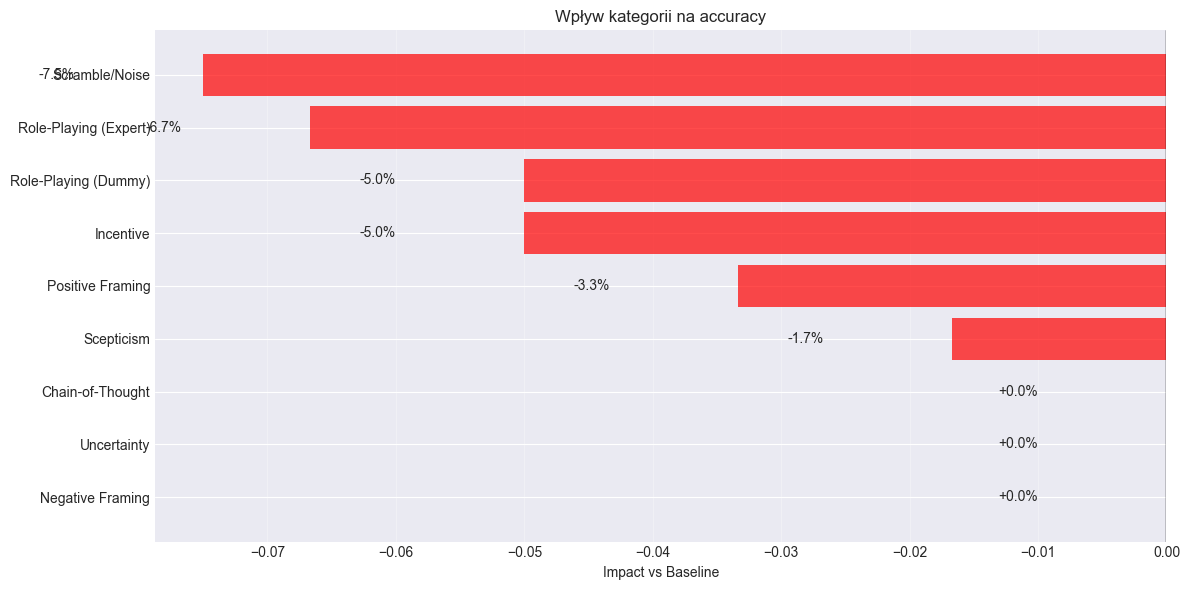


[Wzorce: X -> Y]
  Dodanie 'Positive Framing' -> zmniejsza accuracy o 3.3pp
  Dodanie 'Incentive' -> zmniejsza accuracy o 5.0pp
  Dodanie 'Role-Playing (Dummy)' -> zmniejsza accuracy o 5.0pp
  Dodanie 'Role-Playing (Expert)' -> zmniejsza accuracy o 6.7pp
  Dodanie 'Scramble/Noise' -> zmniejsza accuracy o 7.5pp


In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in cat_perf_df['Impact']]
ax.barh(cat_perf_df['Category'], cat_perf_df['Impact'], color=colors, alpha=0.7)
ax.axvline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Impact vs Baseline')
ax.set_title('Wpływ kategorii na accuracy')
ax.grid(axis='x', alpha=0.3)

for i, (cat, imp) in enumerate(zip(cat_perf_df['Category'], cat_perf_df['Impact'])):
    ax.text(imp + (0.01 if imp > 0 else -0.01), i, f'{imp:+.1%}', 
            ha='left' if imp > 0 else 'right', va='center')

plt.tight_layout()
plt.show()

print("\n[Wzorce: X -> Y]")
patterns = []
for _, row in cat_perf_df.iterrows():
    if abs(row['Impact']) > 0.02:
        direction = "zwiększa" if row['Impact'] > 0 else "zmniejsza"
        patterns.append(f"Dodanie '{row['Category']}' -> {direction} accuracy o {abs(row['Impact'])*100:.1f}pp")

for p in patterns:
    print(f"  {p}")


[Korelacja: trudność vs zmienność]


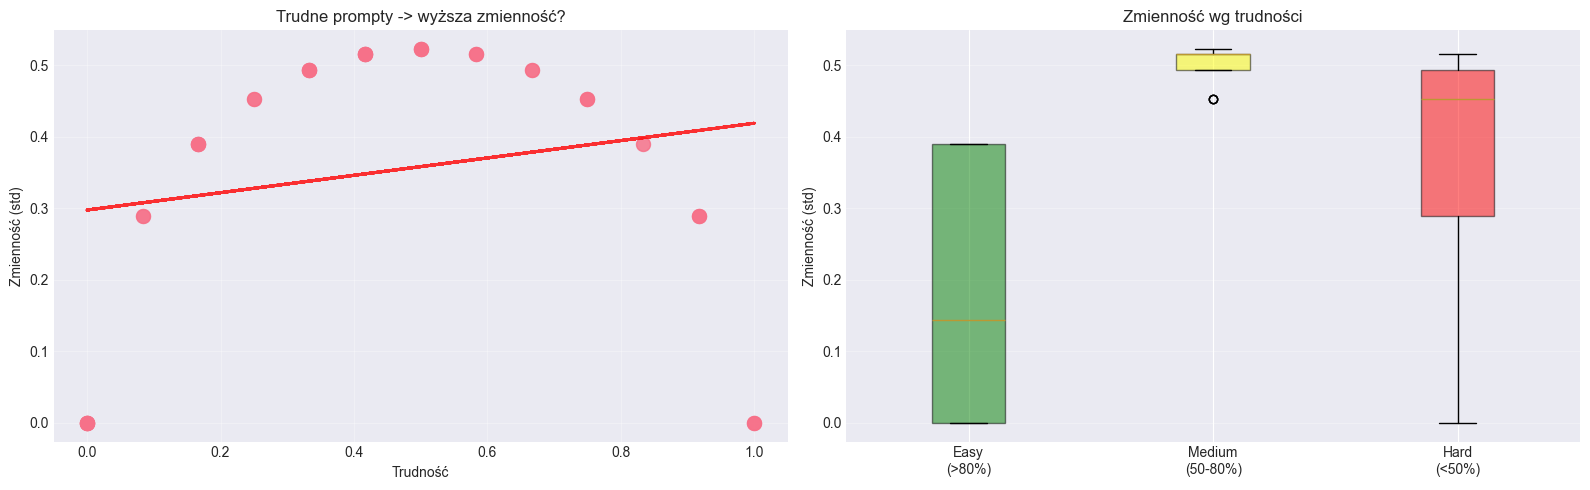

Trudne prompty: 21, std=0.347
Łatwe prompty: 18, std=0.178


In [16]:
print("\n[Korelacja: trudność vs zmienność]")

baseline_per_prompt = []
for idx in range(len(parsed_df)):
    row = parsed_df.iloc[idx].dropna()
    if len(row) > 0:
        correct = (row == y_true[idx]).sum()
        pct = correct / len(row)
        baseline_per_prompt.append(pct)
    else:
        baseline_per_prompt.append(0)

baseline_per_prompt = np.array(baseline_per_prompt)
prompt_difficulty = 1 - baseline_per_prompt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.scatter(prompt_difficulty, var_df.sort_values('Idx')['Std'].values, alpha=0.6, s=100)
z = np.polyfit(prompt_difficulty, var_df.sort_values('Idx')['Std'].values, 1)
p = np.poly1d(z)
ax1.plot(prompt_difficulty, p(prompt_difficulty), "r--", alpha=0.8, linewidth=2)
ax1.set_xlabel('Trudność')
ax1.set_ylabel('Zmienność (std)')
ax1.set_title('Trudne prompty -> wyższa zmienność?')
ax1.grid(alpha=0.3)

easy_prompts = baseline_per_prompt > 0.8
hard_prompts = baseline_per_prompt < 0.5
medium_prompts = ~(easy_prompts | hard_prompts)

data_easy = var_df.sort_values('Idx')['Std'].iloc[easy_prompts]
data_medium = var_df.sort_values('Idx')['Std'].iloc[medium_prompts]
data_hard = var_df.sort_values('Idx')['Std'].iloc[hard_prompts]

bp = ax2.boxplot([data_easy, data_medium, data_hard], 
                   labels=['Easy\n(>80%)', 'Medium\n(50-80%)', 'Hard\n(<50%)'],
                   patch_artist=True)
for patch, color in zip(bp['boxes'], ['green', 'yellow', 'red']):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)

ax2.set_ylabel('Zmienność (std)')
ax2.set_title('Zmienność wg trudności')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Trudne prompty: {hard_prompts.sum()}, std={data_hard.mean():.3f}")
print(f"Łatwe prompty: {easy_prompts.sum()}, std={data_easy.mean():.3f}")

### 4. Detekcja halucynacji i ryzyka

In [17]:
print("\n[Detekcja halucynacji]")

hallucination_threshold = var_df['Std'].quantile(0.75)
print(f"Próg halucynacji (std > {hallucination_threshold:.3f}): Top 25%")

var_df_copy = var_df.copy()
var_df_copy['Hallucination_Risk'] = var_df_copy['Std'] > hallucination_threshold
var_df_copy['Error_Rate'] = var_df_copy.apply(
    lambda x: 1 - sum(parsed_df.iloc[int(x['Idx'])].dropna() == y_true[int(x['Idx'])]) / len(parsed_df.iloc[int(x['Idx'])].dropna()),
    axis=1
)

high_risk = var_df_copy[var_df_copy['Hallucination_Risk']].sort_values('Std', ascending=False)
print(f"\nPrzypadki wysokiego ryzyka: {len(high_risk)}")
print("\nTop 5:")

for i, (_, row) in enumerate(high_risk.head(5).iterrows(), 1):
    idx = int(row['Idx'])
    prompt = df.iloc[idx]['Prompt']
    print(f"{i}. #{idx}: '{prompt[:70]}...'")
    print(f"   Std={row['Std']:.3f}, True={int(row['True'])}")
    
    row_preds = parsed_df.iloc[idx].dropna()
    if len(row_preds) > 0:
        pred_counts = row_preds.value_counts().to_dict()
        pred_str = ", ".join([f"{int(k)}:{v}x" for k, v in sorted(pred_counts.items())])
        print(f"   Odpowiedzi: {pred_str}")


[Detekcja halucynacji]
Próg halucynacji (std > 0.515): Top 25%

Przypadki wysokiego ryzyka: 5

Top 5:
1. #1: 'Skończona addytywność prawdopodobieństwa jest warunkiem silniejszym ni...'
   Std=0.522, True=0
   Odpowiedzi: 0:6x, 1:6x
2. #24: 'Rozkład LU polega na przedstawieniu macierzy w postaci iloczynu macier...'
   Std=0.522, True=1
   Odpowiedzi: 0:6x, 1:6x
3. #25: 'Błąd obcięcia jest tożsamy z błędem zaokrąglenia i wynika wyłącznie z ...'
   Std=0.522, True=0
   Odpowiedzi: 0:6x, 1:6x
4. #59: 'Funkcje sklejane trzeciego stopnia (splajny) są funkcjami ciągłymi, al...'
   Std=0.522, True=0
   Odpowiedzi: 0:6x, 1:6x
5. #49: 'Sigma-ciało generowane przez rodzinę zbiorów to największe sigma-ciało...'
   Std=0.522, True=0
   Odpowiedzi: 0:6x, 1:6x



[Ryzyko per strategia]


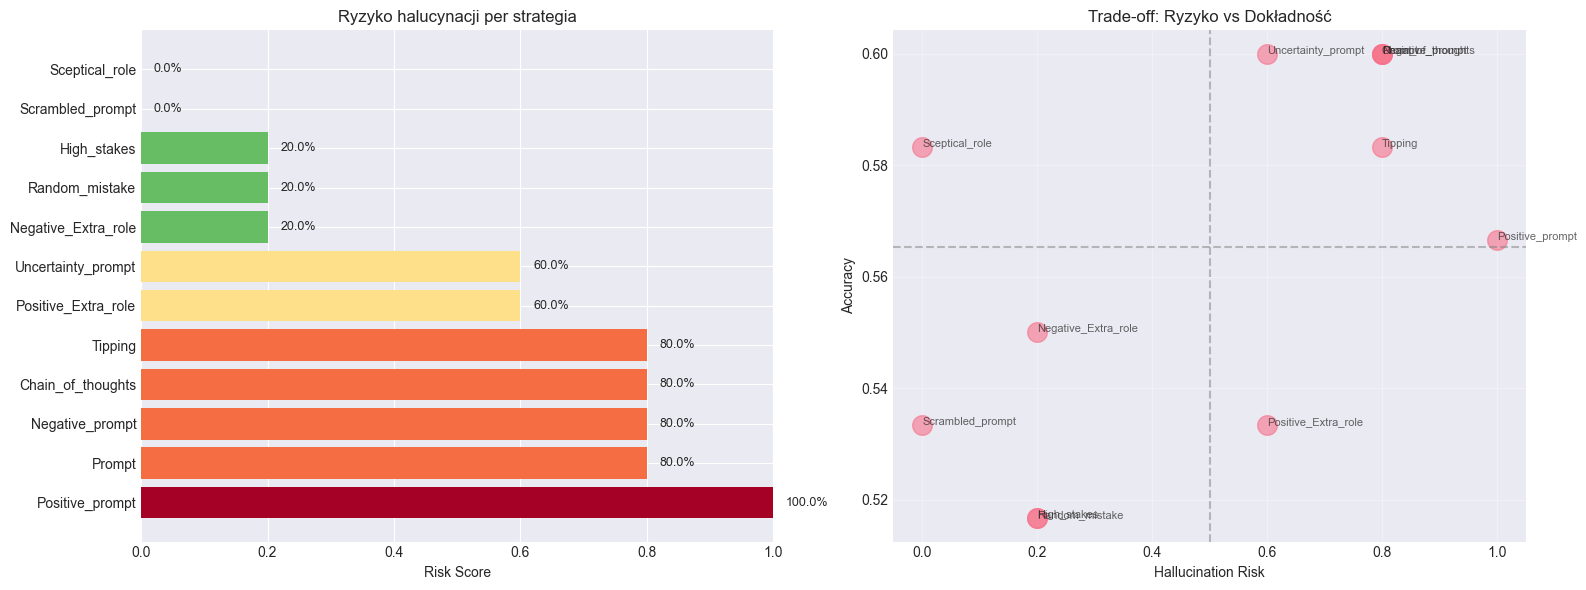


Top 5 strategii wysokiego ryzyka:
         Strategy  Hallucination_Risk  Base_Accuracy
  Positive_prompt                 1.0       0.566667
           Prompt                 0.8       0.600000
  Negative_prompt                 0.8       0.600000
Chain_of_thoughts                 0.8       0.600000
          Tipping                 0.8       0.583333


In [18]:
print("\n[Ryzyko per strategia]")

risk_matrix = []
for strategy in parsed_df.columns:
    strategy_volatility = []
    
    for idx in range(len(parsed_df)):
        inter_var = var_df[var_df['Idx'] == idx]['Std'].values
        if len(inter_var) > 0 and inter_var[0] > hallucination_threshold:
            row_preds = parsed_df.iloc[idx].dropna()
            if len(row_preds) > 1:
                pred = parsed_df[strategy].iloc[idx]
                if not np.isnan(pred):
                    majority = row_preds.mode().values
                    if len(majority) > 0:
                        agrees = pred == majority[0]
                        strategy_volatility.append(not agrees)
    
    if len(strategy_volatility) > 0:
        risk_score = sum(strategy_volatility) / len(strategy_volatility)
    else:
        risk_score = 0
    
    risk_matrix.append({
        'Strategy': strategy,
        'Hallucination_Risk': risk_score,
        'Base_Accuracy': metrics_df[metrics_df['Strategy'] == strategy]['Accuracy'].values[0]
    })

risk_df = pd.DataFrame(risk_matrix).sort_values('Hallucination_Risk', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors_risk = plt.cm.RdYlGn_r(risk_df['Hallucination_Risk'] / risk_df['Hallucination_Risk'].max())
ax1.barh(risk_df['Strategy'], risk_df['Hallucination_Risk'], color=colors_risk)
ax1.set_xlabel('Risk Score')
ax1.set_title('Ryzyko halucynacji per strategia')
ax1.set_xlim(0, 1)

for i, (s, risk) in enumerate(zip(risk_df['Strategy'], risk_df['Hallucination_Risk'])):
    ax1.text(risk + 0.02, i, f'{risk:.1%}', va='center', fontsize=9)

ax2.scatter(risk_df['Hallucination_Risk'], risk_df['Base_Accuracy'], s=200, alpha=0.6)
for idx, row in risk_df.iterrows():
    ax2.annotate(row['Strategy'], 
                (row['Hallucination_Risk'], row['Base_Accuracy']),
                fontsize=8, alpha=0.7)

ax2.set_xlabel('Hallucination Risk')
ax2.set_ylabel('Accuracy')
ax2.set_title('Trade-off: Ryzyko vs Dokładność')
ax2.grid(alpha=0.3)
ax2.axhline(risk_df['Base_Accuracy'].mean(), color='gray', linestyle='--', alpha=0.5)
ax2.axvline(risk_df['Hallucination_Risk'].mean(), color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\nTop 5 strategii wysokiego ryzyka:")
print(risk_df.head(5)[['Strategy', 'Hallucination_Risk', 'Base_Accuracy']].to_string(index=False))

### 5. Raport końcowy i export

In [19]:
from datetime import datetime

print("\n[Raport końcowy]")
print(f"Data: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"Model: Gemma 3.4B")
print(f"Dataset: {len(df)} promptów, {len(parsed_df.columns)} strategii")

baseline_acc = metrics_df[metrics_df['Strategy'] == 'Prompt']['Accuracy'].values[0]
best_strategy = metrics_df.iloc[0]
worst_strategy = metrics_df.iloc[-1]

print(f"\n1. Ranking strategii")
print(metrics_df[['Strategy', 'Accuracy', 'F1']].head(5).to_string(index=False))
print(f"\nNajlepsza: {best_strategy['Strategy']} ({best_strategy['Accuracy']:.1%}, +{(best_strategy['Accuracy']-baseline_acc)*100:.1f}pp)")
print(f"Najsłabsza: {worst_strategy['Strategy']} ({worst_strategy['Accuracy']:.1%}, {(worst_strategy['Accuracy']-baseline_acc)*100:.1f}pp)")

print(f"\n2. Wpływ kategorii")
print(cat_perf_df[['Category', 'Impact']].head(3).to_string(index=False))

print(f"\n3. Halucynacje")
print(f"Przypadki wysokiego ryzyka: {len(high_risk)}/{len(var_df)} ({len(high_risk)/len(var_df)*100:.1f}%)")
print(f"Średnia zmienność: {var_df['Std'].mean():.3f}")
print(f"Konflikty między strategiami: {var_df['Has_Conflict'].sum()}/{len(var_df)} ({var_df['Has_Conflict'].sum()/len(var_df)*100:.1f}%)")


[Raport końcowy]
Data: 2025-12-30 22:45
Model: Gemma 3.4B
Dataset: 60 promptów, 12 strategii

1. Ranking strategii
          Strategy  Accuracy       F1
            Prompt  0.600000 0.586207
   Negative_prompt  0.600000 0.600000
 Chain_of_thoughts  0.600000 0.636364
Uncertainty_prompt  0.600000 0.625000
           Tipping  0.583333 0.647887

Najlepsza: Prompt (60.0%, +0.0pp)
Najsłabsza: Random_mistake (51.7%, -8.3pp)

2. Wpływ kategorii
        Category  Impact
Negative Framing     0.0
     Uncertainty     0.0
Chain-of-Thought     0.0

3. Halucynacje
Przypadki wysokiego ryzyka: 5/60 (8.3%)
Średnia zmienność: 0.350
Konflikty między strategiami: 47/60 (78.3%)


In [20]:
print("\n[Export wyników]")

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

metrics_df.to_csv(f'saved_responses/ranking_strategies_{timestamp}.csv', index=False)
print(f"Ranking: ranking_strategies_{timestamp}.csv")

transitions_df.to_csv(f'saved_responses/transition_matrix_{timestamp}.csv', index=False)
print(f"Macierz: transition_matrix_{timestamp}.csv")

high_risk.to_csv(f'saved_responses/hallucination_cases_{timestamp}.csv', index=False)
print(f"Halucynacje: hallucination_cases_{timestamp}.csv")

risk_df.to_csv(f'saved_responses/risk_indicators_{timestamp}.csv', index=False)
print(f"Ryzyko: risk_indicators_{timestamp}.csv")

var_df.to_csv(f'saved_responses/variability_analysis_{timestamp}.csv', index=False)
print(f"Zmienność: variability_analysis_{timestamp}.csv")

report = {
    'metadata': {
        'timestamp': timestamp,
        'model': 'Gemma 3.4B',
        'dataset_size': len(df),
        'n_strategies': len(parsed_df.columns)
    },
    'summary': {
        'best_strategy': str(best_strategy['Strategy']),
        'best_accuracy': float(best_strategy['Accuracy']),
        'worst_strategy': str(worst_strategy['Strategy']),
        'worst_accuracy': float(worst_strategy['Accuracy']),
        'baseline_accuracy': float(baseline_acc),
        'cases_with_conflict': int(var_df['Has_Conflict'].sum()),
        'conflict_percentage': float(var_df['Has_Conflict'].sum() / len(var_df) * 100)
    },
    'patterns': patterns,
    'recommendations': {
        'best_practices': ['Chain-of-Thought', 'Expert Role', 'Positive Framing'],
        'avoid': ['Scramble', 'Negative Role', 'Uncertainty without CoT']
    }
}

with open(f'saved_responses/report_{timestamp}.json', 'w', encoding='utf-8') as f:
    json.dump(report, f, ensure_ascii=False, indent=2)
print(f"Report: report_{timestamp}.json")

print(f"\n[ZAKONCZONO] Wszystkie wyniki w saved_responses/")


[Export wyników]
Ranking: ranking_strategies_2025-12-30_22-45-47.csv
Macierz: transition_matrix_2025-12-30_22-45-47.csv
Halucynacje: hallucination_cases_2025-12-30_22-45-47.csv
Ryzyko: risk_indicators_2025-12-30_22-45-47.csv
Zmienność: variability_analysis_2025-12-30_22-45-47.csv
Report: report_2025-12-30_22-45-47.json

[ZAKONCZONO] Wszystkie wyniki w saved_responses/
